## A speech-to-text model that learns to understand audio data as text.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D,BatchNormalization,MaxPooling2D,Flatten,Dense,Dropout
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from IPython import display
import random
from sklearn.model_selection import train_test_split

cd = Path.cwd()
filepath = os.path.join(cd,r'OneDrive\Desktop\Datasets\audio-commands\SpeechDataset')

### Each piece of data is a second-long clip of someone articulating one of 35 words (written below.) For the model to learn to generalize as much as possible, the speakers have a diversity of accents, ages, and pronounciations, and the clips vary in recording quality and background noise. 

In [2]:
classes = os.listdir(filepath)
classes = sorted(classes)

to_remove = ['_background_noise_','LICENSE','testing_list.txt','README.md','validation_list.txt',]

for i in to_remove:
    classes.remove(i)
    
num_classes = len(classes)
    
print('There are {} classes:'.format(num_classes))
print(classes)

There are 35 classes:
['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']


### A series of functions extract and transform the data, either to display for listening purposes, to be fed into the model, or to be transformed into spectograms and displayed as such.

In [3]:
def extract_wav(path):
    
    sound = tf.io.read_file(path)
    sound = tf.audio.decode_wav(sound)[0]
    sound = tf.squeeze(sound)
    
    return sound


def extract_sound(path):
    
    wav = tf.io.read_file(path)
    wav = tf.audio.decode_wav(wav)
    sound = tf.squeeze(wav[0]).numpy()
    rate = wav[1].numpy()
    audio = display.Audio(sound,rate=rate)
    
    return audio


make_spectogram = lambda wav: tf.abs(tf.signal.stft(wav,frame_length=255,frame_step=128))

height = 124
width = 129


sns.set_style('darkgrid')
def plot_wave_and_spectogram(path):
    
    sound = extract_wav(path)
    spectogram = make_spectogram(sound)
    log_spec = tf.math.log(tf.transpose(spectogram))
    
    x = np.linspace(0,np.size(spectogram),log_spec.shape[1],dtype='int')
    y = range(log_spec.shape[0])
    
    plt.subplot(2,1,1)
    plt.plot(sound)
    plt.subplot(2,1,2)
    plt.pcolormesh(x,y,log_spec,cmap='turbo')
    plt.show()

In [4]:
audio_files = []
labels = []

for sound_class in classes:
    class_filepath = os.path.join(filepath,sound_class)
    class_filepath_images = sorted(os.listdir(class_filepath))
    for audio_file in class_filepath_images:
        audio_files.append(os.path.join(class_filepath,audio_file))
        labels.append(classes.index(sound_class))

### A few examples of words with sound:

Word: three


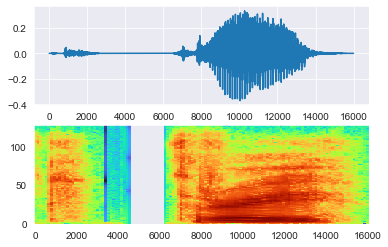



 ---------------------------------------------------------------------- 


Word: four


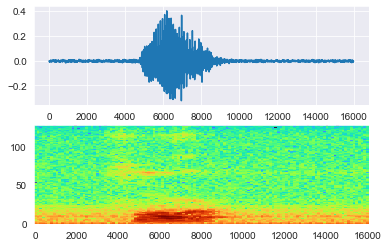



 ---------------------------------------------------------------------- 


Word: tree


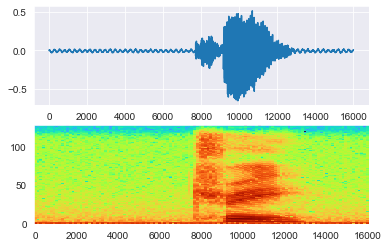



 ---------------------------------------------------------------------- 


Word: off


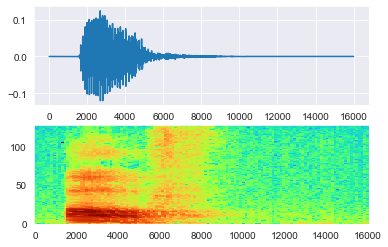



 ---------------------------------------------------------------------- 


Word: up


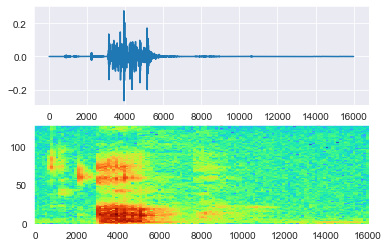



 ---------------------------------------------------------------------- 


Word: no


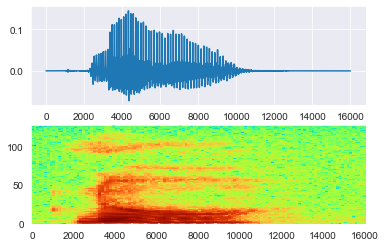



 ---------------------------------------------------------------------- 


Word: zero


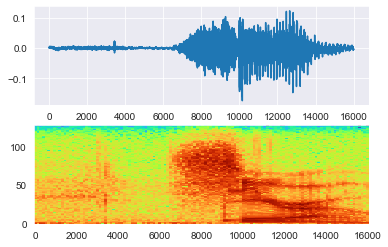



 ---------------------------------------------------------------------- 


Word: down


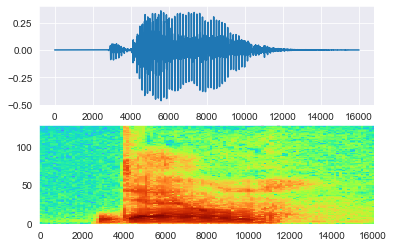



 ---------------------------------------------------------------------- 


Word: five


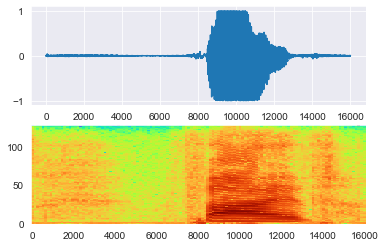



 ---------------------------------------------------------------------- 


Word: nine


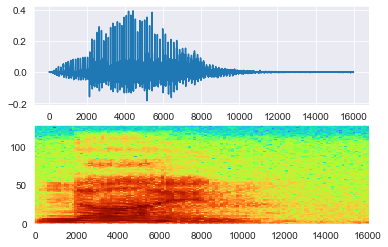



 ---------------------------------------------------------------------- 




In [5]:
for i in range(10):
    
    n = random.randint(0,len(audio_files)-1)
    path = audio_files[n]
    sound = extract_sound(path)
    label = classes[labels[n]]
    print('Word:',label)
    display.display(sound)
    plot_wave_and_spectogram(path)
    print('\n\n {} \n\n'.format('-'*70))

### The data is split into training and test data.

In [6]:
train_audio_files,test_audio_files,train_labels,test_labels = train_test_split(audio_files,
                                                                              labels,
                                                                              test_size=.02,
                                                                              random_state=1)

In [7]:
def process_file(file,label):
    
    s = extract_wav(file)
    s = make_spectogram(s)
    s = tf.expand_dims(s,axis=-1)
    if tf.shape(s)[0] < height:
        z = tf.zeros((height-tf.shape(s)[0],width,1))
        s = tf.concat([s,z],axis=0)
    
    return s,label


batch_size = 32

def make_dataset(files,labels):
    
    dataset = tf.data.Dataset.from_tensor_slices((files,labels))
    dataset = dataset.map(process_file)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return dataset

train_dataset = make_dataset(train_audio_files,train_labels)
test_dataset = make_dataset(test_audio_files,test_labels)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


### As spectograms, the sounds as represented as 2-dimensional images. A convolutional nueral network can learn the features and predict the text.

In [8]:
dropout_size = .25

inputs = keras.Input(shape=(height,width,1))
X = BatchNormalization()(inputs)

filters = 16
for i in range(5):
    X = Conv2D(filters,(3,3),activation='selu')(X)
    X = MaxPooling2D(2)(X)
    X = BatchNormalization()(X)
    X = Dropout(dropout_size)(X)
    filters *= 2
    
X = Flatten()(X)

for i in range(3):
    X = Dense(512,activation='selu')(X)
    X = BatchNormalization()(X)
    X = Dropout(dropout_size)(X)
    
output = Dense(num_classes,activation='softmax')(X)
    
model = keras.Model(inputs=inputs,
                   outputs=output)

optimizer = keras.optimizers.Adam(1e-3)
model.compile(loss='sparse_categorical_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 124, 129, 1)]     0         
                                                                 
 batch_normalization (BatchN  (None, 124, 129, 1)      4         
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 122, 127, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 61, 63, 16)       0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 61, 63, 16)       64        
 hNormalization)                                                 
                                                             

### The model trains for 15 epochs:

In [9]:
epochs = 15
    
history = model.fit(train_dataset,
                   validation_data=test_dataset,
                   epochs=epochs)

Epoch 1/15
3241/3241 [==============================] - 2413s 742ms/step - loss: 1.7664 - accuracy: 0.5011 - val_loss: 0.8740 - val_accuracy: 0.7459
Epoch 2/15
3241/3241 [==============================] - 2159s 666ms/step - loss: 0.9616 - accuracy: 0.7166 - val_loss: 0.6682 - val_accuracy: 0.8007
Epoch 3/15
3241/3241 [==============================] - 2922s 902ms/step - loss: 0.7968 - accuracy: 0.7630 - val_loss: 0.5718 - val_accuracy: 0.8299
Epoch 4/15
3241/3241 [==============================] - 28909s 9s/step - loss: 0.7137 - accuracy: 0.7882 - val_loss: 0.5520 - val_accuracy: 0.8281
Epoch 5/15
3241/3241 [==============================] - 2695s 832ms/step - loss: 0.6597 - accuracy: 0.8045 - val_loss: 0.5281 - val_accuracy: 0.8413
Epoch 6/15
3241/3241 [==============================] - 2926s 903ms/step - loss: 0.6215 - accuracy: 0.8154 - val_loss: 0.5483 - val_accuracy: 0.8347
Epoch 7/15
3241/3241 [==============================] - 2560s 790ms/step - loss: 0.5894 - accuracy: 0.8239 -

### The training progress, in terms of loss and accuracy, is plotted; for both training and test data. The model currently has an ~88% accuracy on the test data. Since the loss was continuing to decrease, the model would have benefitted from more time training, especially with a decreased learning rate.

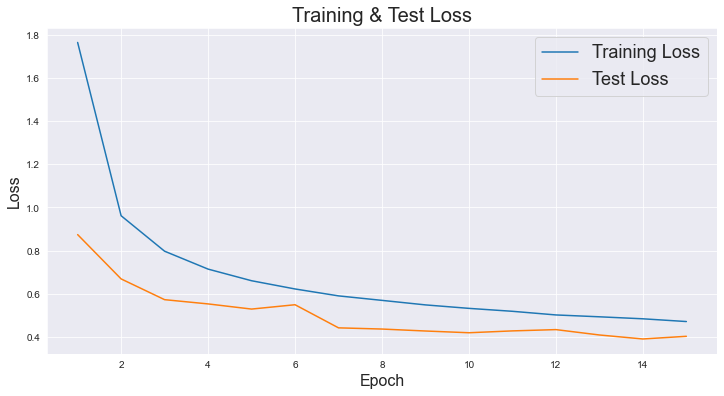

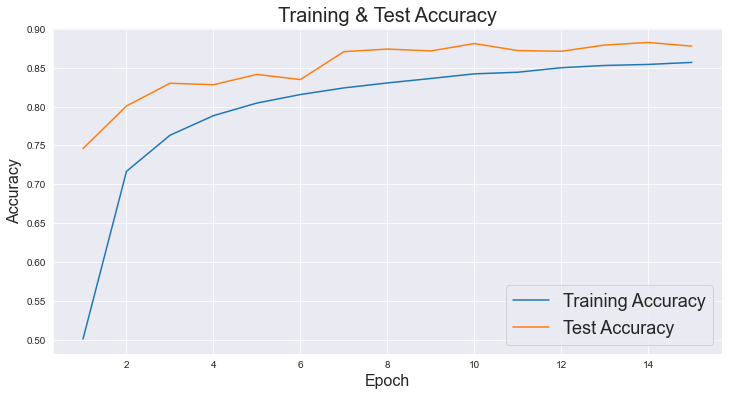

In [12]:
hist = history.history 
epoch = np.arange(epochs) + 1

def plot_metric(metric):
    
    train_metric = hist[metric]
    test_metric = hist['val_'+metric]
    plt.figure(figsize=(12,6))
    plt.plot(epoch,train_metric)
    plt.plot(epoch,test_metric)

    metric_title = metric.title()
    plt.title('Training & Test '+metric_title,fontdict={'fontsize':20})
    plt.xlabel('Epoch',fontdict={'fontsize':16})
    plt.ylabel(metric_title,fontdict={'fontsize':16})
    plt.legend(['Training '+metric_title,
               'Test '+metric_title],
              prop={'size':18})
    plt.show()
    
plot_metric('loss')
plot_metric('accuracy')

### Some examples of the model predicting samples from the test data, sound included:

In [11]:
num_samples = 40

n = random.sample(range(len(test_audio_files)),num_samples)

for i in n:
    path = test_audio_files[i]
    spec,_ = process_file(path,_)
    prediction = model.predict(tf.expand_dims(spec,axis=0),verbose=0)
    prediction = tf.argmax(tf.squeeze(prediction))
    predicted_label = classes[prediction]
    correct_label = classes[test_labels[i]]
    sound = extract_sound(path)
    
    display.display(sound)
    print('Predicted word:',predicted_label)
    print('Correct word:',correct_label)
    print('\n{}\n'.format('-'*60))

Predicted word: seven
Correct word: seven

------------------------------------------------------------



Predicted word: two
Correct word: two

------------------------------------------------------------



Predicted word: happy
Correct word: four

------------------------------------------------------------



Predicted word: on
Correct word: on

------------------------------------------------------------



Predicted word: seven
Correct word: seven

------------------------------------------------------------



Predicted word: four
Correct word: four

------------------------------------------------------------



Predicted word: three
Correct word: five

------------------------------------------------------------



Predicted word: house
Correct word: house

------------------------------------------------------------



Predicted word: visual
Correct word: visual

------------------------------------------------------------



Predicted word: off
Correct word: house

------------------------------------------------------------



Predicted word: nine
Correct word: nine

------------------------------------------------------------



Predicted word: off
Correct word: off

------------------------------------------------------------



Predicted word: happy
Correct word: happy

------------------------------------------------------------



Predicted word: down
Correct word: down

------------------------------------------------------------



Predicted word: zero
Correct word: six

------------------------------------------------------------



Predicted word: seven
Correct word: seven

------------------------------------------------------------



Predicted word: nine
Correct word: nine

------------------------------------------------------------



Predicted word: cat
Correct word: cat

------------------------------------------------------------



Predicted word: up
Correct word: off

------------------------------------------------------------



Predicted word: sheila
Correct word: zero

------------------------------------------------------------



Predicted word: eight
Correct word: visual

------------------------------------------------------------



Predicted word: five
Correct word: five

------------------------------------------------------------



Predicted word: bed
Correct word: bed

------------------------------------------------------------



Predicted word: bed
Correct word: bed

------------------------------------------------------------



Predicted word: seven
Correct word: seven

------------------------------------------------------------



Predicted word: tree
Correct word: stop

------------------------------------------------------------



Predicted word: off
Correct word: off

------------------------------------------------------------



Predicted word: nine
Correct word: nine

------------------------------------------------------------



Predicted word: off
Correct word: off

------------------------------------------------------------



Predicted word: happy
Correct word: happy

------------------------------------------------------------



Predicted word: bird
Correct word: bird

------------------------------------------------------------



Predicted word: marvin
Correct word: marvin

------------------------------------------------------------



Predicted word: sheila
Correct word: sheila

------------------------------------------------------------



Predicted word: dog
Correct word: dog

------------------------------------------------------------



Predicted word: two
Correct word: two

------------------------------------------------------------



Predicted word: no
Correct word: no

------------------------------------------------------------



Predicted word: backward
Correct word: backward

------------------------------------------------------------



Predicted word: stop
Correct word: stop

------------------------------------------------------------



Predicted word: right
Correct word: right

------------------------------------------------------------



Predicted word: six
Correct word: six

------------------------------------------------------------

